### 1. Wheel Travel vs. Camber, Toe and Track Alteration: Baseline Curves

Best fitted functions are cubic as follows.


                    CAMBER DATA ANALYSIS                    

Analyzing Camber Angle data (n=20)
Linear       - R²: 0.937298
Quadratic    - R²: 0.982273
Cubic        - R²: 0.991234
Power        - R²: 0.807772
Exponential  - R²: 0.987590
Logarithmic  - R²: 0.424890
Sinusoidal   - R²: 0.174567

Best fit for Camber Angle: Cubic
Function parameters: [-48.76258113   3.03680145 -37.87645218 -28.72789553]


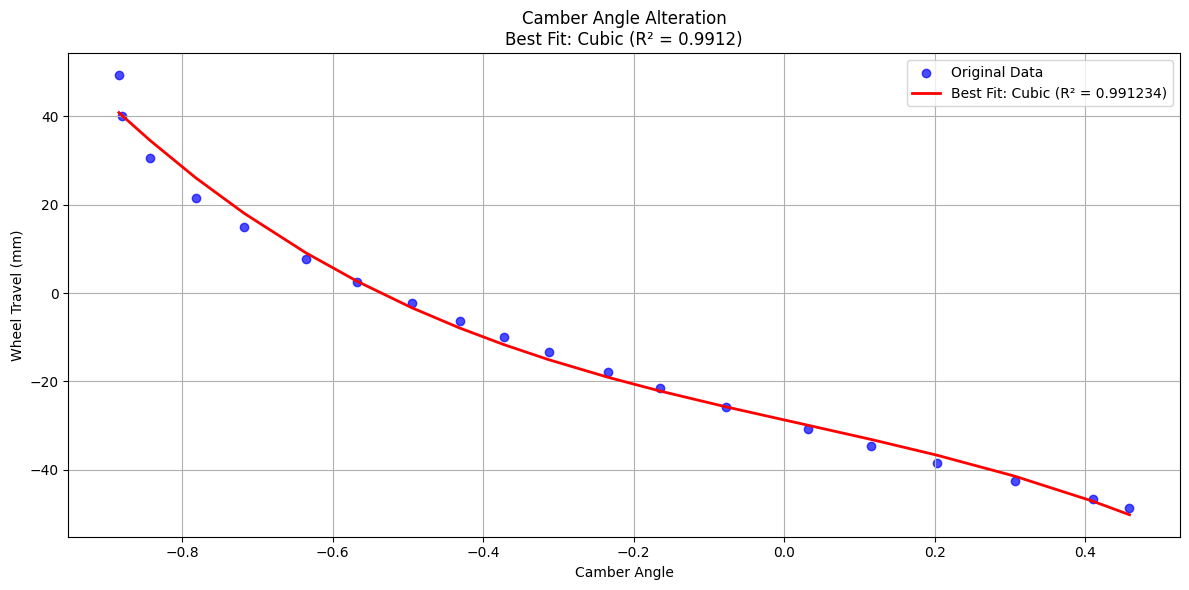


                     TOE DATA ANALYSIS                      

Analyzing Toe Angle data (n=25)
Linear       - R²: 0.947897
Quadratic    - R²: 0.990630
Cubic        - R²: 0.998117
Power        - R²: 0.394194
Exponential  - R²: 0.995422
Logarithmic  - R²: -0.000000
Sinusoidal   - R²: 0.990628

Best fit for Toe Angle: Cubic
Function parameters: [26.12141996 59.97397949 79.71489359  6.19447021]


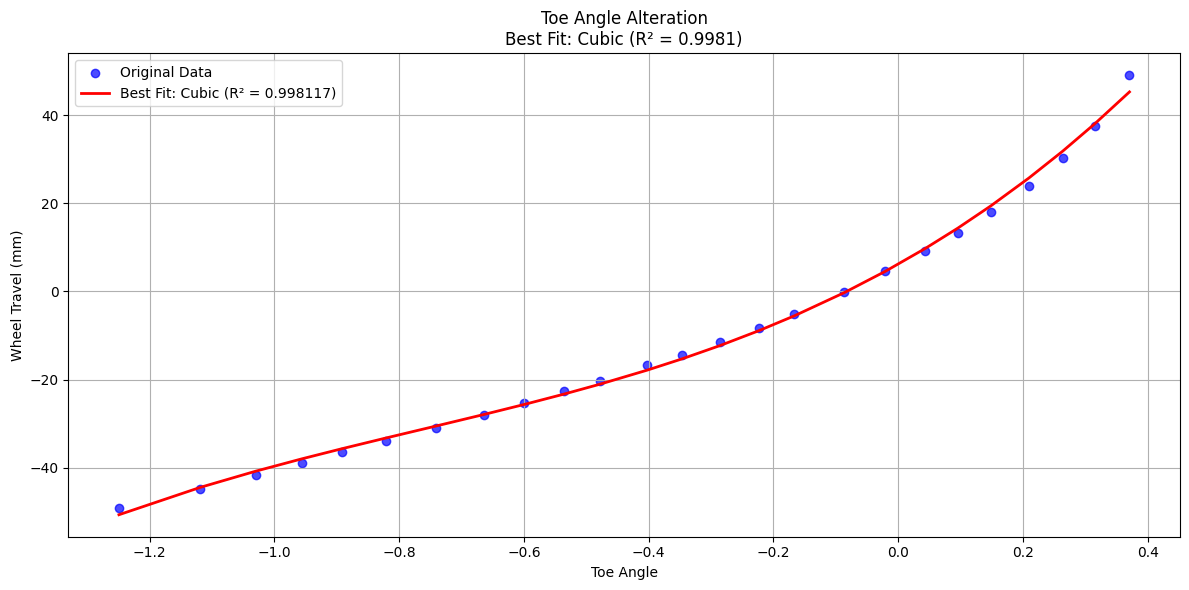


                    TRACK DATA ANALYSIS                     

Analyzing Track data (n=38)
Linear       - R²: 0.782972
Quadratic    - R²: 0.832864
Cubic        - R²: 0.834467
Power        - Failed: Optimal parameters not found: The maximum number o...
Exponential  - Failed: Residuals are not finite in the initial point....
Logarithmic  - R²: 0.782258
Sinusoidal   - R²: 0.012660

Best fit for Track: Cubic
Function parameters: [ 5.82353414e-03 -2.68903521e+01  4.13904475e+04 -2.12372593e+07]


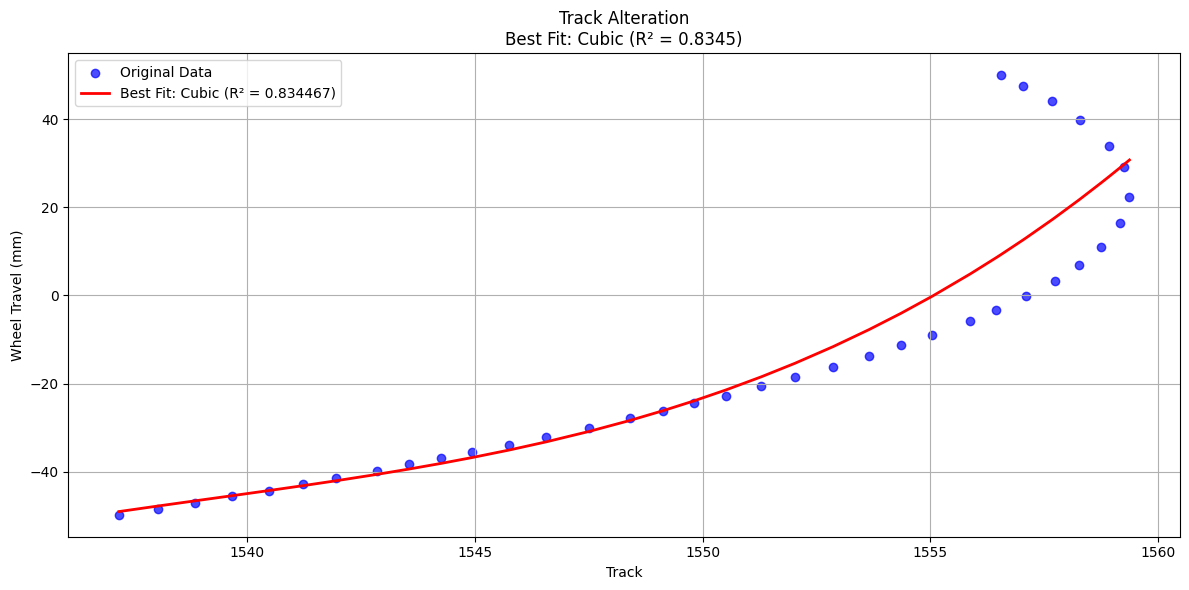

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Define all possible fitting functions with bounds
def linear_func(x, a, b):
    return a * x + b

def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

def cubic_func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def power_func(x, a, b, c):
    with np.errstate(all='ignore'):
        return a * np.power(np.abs(x), b) + c  # Added abs() to handle negative x

def exp_func(x, a, b, c):
    with np.errstate(all='ignore'):
        return a * np.exp(b * x) + c

def log_func(x, a, b, c):
    with np.errstate(all='ignore'):
        return a * np.log(np.abs(b) * np.abs(x) + 1e-10) + c  # Added small offset

def sin_func(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

# Store all functions with their names and parameter bounds
functions = [
    {'name': 'Linear', 'func': linear_func, 'bounds': (-np.inf, np.inf)},
    {'name': 'Quadratic', 'func': quadratic_func, 'bounds': (-np.inf, np.inf)},
    {'name': 'Cubic', 'func': cubic_func, 'bounds': (-np.inf, np.inf)},
    {'name': 'Power', 'func': power_func, 'bounds': ([0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])},
    {'name': 'Exponential', 'func': exp_func, 'bounds': ([0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])},
    {'name': 'Logarithmic', 'func': log_func, 'bounds': ([0, 1e-10, -np.inf], [np.inf, np.inf, np.inf])},
    {'name': 'Sinusoidal', 'func': sin_func, 'bounds': ([0, 0, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])}
]

def find_best_fit(x, y, dataset_name):
    best_r2 = -np.inf
    best_result = None
    
    print(f"\nAnalyzing {dataset_name} data (n={len(x)})")
    print("="*40)
    
    for func_info in functions:
        try:
            # Filter out NaN/inf values
            mask = np.isfinite(x) & np.isfinite(y)
            x_clean = x[mask]
            y_clean = y[mask]
            
            # Initial parameter guesses
            p0 = [1.0] * len(func_info['func'].__code__.co_varnames[1:])
            
            # Perform the fit with bounds
            popt, pcov = curve_fit(func_info['func'], x_clean, y_clean, 
                                  p0=p0, bounds=func_info['bounds'],
                                  maxfev=10000)
            
            # Calculate predictions and R²
            y_pred = func_info['func'](x_clean, *popt)
            r2 = r2_score(y_clean, y_pred)
            
            # Store all results
            result = {
                'name': func_info['name'],
                'func': func_info['func'],
                'params': popt,
                'r2': r2,
                'y_pred': func_info['func'](x, *popt)  # Prediction on original x
            }
            
            print(f"{func_info['name']:12} - R²: {r2:.6f}")
            
            if r2 > best_r2 and np.isfinite(r2):
                best_r2 = r2
                best_result = result
                
        except Exception as e:
            print(f"{func_info['name']:12} - Failed: {str(e)[:50]}...")
            continue
    
    return best_result

def plot_results(x, y, result, dataset_name):
    plt.figure(figsize=(12, 6))
    plt.scatter(x, y, label='Original Data', color='blue', alpha=0.7)
    
    if result:
        # Sort for clean plotting
        sort_idx = np.argsort(x)
        x_sorted = x[sort_idx]
        y_pred_sorted = result['y_pred'][sort_idx]
        
        plt.plot(x_sorted, y_pred_sorted, 'r-', linewidth=2,
                label=f'Best Fit: {result["name"]} (R² = {result["r2"]:.6f})')
        
        plt.title(f'{dataset_name} Alteration\nBest Fit: {result["name"]} (R² = {result["r2"]:.4f})')
        print(f"\nBest fit for {dataset_name}: {result['name']}")
        print("Function parameters:", result['params'])
    else:
        plt.title(f'{dataset_name} Alteration - No suitable fit found')
    
    plt.xlabel(dataset_name)
    plt.ylabel("Wheel Travel (mm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Load all datasets
camber_df = pd.read_csv("camber_alteration.csv")
toe_df = pd.read_csv("toe_alteration.csv")
track_df = pd.read_csv("track_alteration.csv")

# Process Camber data
print("\n" + "="*60)
print("CAMBER DATA ANALYSIS".center(60))
print("="*60)
camber_result = find_best_fit(camber_df["x"].values, camber_df["y"].values, "Camber Angle")
plot_results(camber_df["x"].values, camber_df["y"].values, camber_result, "Camber Angle")

# Process Toe data
print("\n" + "="*60)
print("TOE DATA ANALYSIS".center(60))
print("="*60)
toe_result = find_best_fit(toe_df["x"].values, toe_df["y"].values, "Toe Angle")
plot_results(toe_df["x"].values, toe_df["y"].values, toe_result, "Toe Angle")

# Process Track data
print("\n" + "="*60)
print("TRACK DATA ANALYSIS".center(60))
print("="*60)
track_result = find_best_fit(track_df["x"].values, track_df["y"].values, "Track")
plot_results(track_df["x"].values, track_df["y"].values, track_result, "Track")

#### Camber:
$s(\epsilon) = -48.76258113 x^3 + 3.03680145 x^2 - 37.87645218 x -28.72789553$

#### Toe:
$s(\tau) = 26.12141996 x^3 + 59.97397949 x^2 + 79.71489359 x + 6.19447021$

#### Track:
$s(b) = (5.82353414e-03) x^3 - (2.68903521e+01) x^2 + (4.13904475e+04) x - (2.12372593e+07)$

### 2. Dataset Extraction Based on the DOE Experiment (Sensitivity Analysis)

In [2]:
import csv

# Define the regression formulas
def calculate_camber(F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12):
    return (4.4686 
            - 1.3297e-4 * F1 
            - 3.5092e-4 * F2 
            + 3.2059e-3 * F3 
            + 2.9229e-5 * F4 
            - 7.2766e-5 * F5 
            + 1.5516e-3 * F6 
            - 5.2122e-4 * F7 
            + 4.1222e-4 * F8 
            - 4.5559e-3 * F9 
            + 8.3043e-4 * F10 
            + 5.7845e-3 * F11 
            - 1.1116e-3 * F12)

def calculate_toe(F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12):
    return (1.5261 
            + 2.3629e-5 * F1 
            + 1.0878e-4 * F2 
            - 5.5909e-3 * F3 
            - 2.4836e-3 * F4 
            - 3.0625e-4 * F5 
            - 8.0725e-3 * F6 
            + 3.1017e-3 * F7 
            - 3.0418e-4 * F8 
            + 1.5253e-2 * F9 
            + 9.1023e-4 * F10 
            + 1.3966e-3 * F11 
            - 2.0041e-4 * F12)

def calculate_track(F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12):
    return (13.7968 
            - 1.5747e-3 * F1 
            - 5.5609e-3 * F2 
            + 4.5056e-2 * F3 
            - 1.7605e-3 * F4 
            - 2.6833e-3 * F5 
            + 3.2607e-2 * F6 
            - 3.6524e-3 * F7 
            + 6.4920e-3 * F8 
            - 7.2687e-2 * F9 
            + 1.4644e-3 * F10 
            + 9.8420e-3 * F11 
            - 1.9373e-3 * F12)

# Define nominal values for other factors (from the HTML file)
nominal_values = {
    'F1': 60,    # hpl_lca_front.x
    'F2': -400,  # hpl_lca_front.y
    'F4': 460,   # hpl_lca_rear.x
    'F5': -390,  # hpl_lca_rear.y
    'F6': 205,   # hpl_lca_rear.z
    'F7': 240,   # hpl_lca_outer.x
    'F8': -700,  # hpl_lca_outer.y
    'F10': 317.5, # hpl_top_mount.x
    'F12': 755    # hpl_top_mount.z
}

# Create ranges for the variables we want to vary
hpl_top_mount_y = np.linspace(-600, -560, 20)  # F11
hpl_lca_outer_z = np.linspace(155, 195, 20)    # F9
hpl_lca_front_z = np.linspace(170, 210, 20)    # F3

# Generate all combinations
data = []
for F11 in hpl_top_mount_y:
    for F9 in hpl_lca_outer_z:
        for F3 in hpl_lca_front_z:
            # Set all factors (using nominal values for fixed factors)
            factors = {
                'F1': nominal_values['F1'],
                'F2': nominal_values['F2'],
                'F3': F3,
                'F4': nominal_values['F4'],
                'F5': nominal_values['F5'],
                'F6': nominal_values['F6'],
                'F7': nominal_values['F7'],
                'F8': nominal_values['F8'],
                'F9': F9,
                'F10': nominal_values['F10'],
                'F11': F11,
                'F12': nominal_values['F12']
            }
            
            # Calculate responses
            camber = calculate_camber(**factors)
            toe = calculate_toe(**factors)
            track = calculate_track(**factors)
            
            # Add to dataset
            data.append([F11, F9, F3, camber, toe, track])

# Write to CSV
filename = 'suspension_geometry.csv'
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['hpl_top_mount.y', 'hpl_lca_outer.z', 'hpl_lca_front.z', 
                     'camber_angle', 'toe_angle', 'track'])
    writer.writerows(data)

print(f"CSV file '{filename}' generated successfully with {len(data)} rows.")

CSV file 'suspension_geometry.csv' generated successfully with 8000 rows.


In [3]:
suspension_df = pd.read_csv("suspension_geometry.csv")
suspension_df

,hpl_top_mount.y,hpl_lca_outer.z,hpl_lca_front.z,camber_angle,toe_angle,track
0,-600.0,155.0,170.000000,0.339787,0.476949,6.916914
1,-600.0,155.0,172.105263,0.346536,0.465179,7.011769
2,-600.0,155.0,174.210526,0.353286,0.453409,7.106624
3,-600.0,155.0,176.315789,0.360035,0.441638,7.201479
4,-600.0,155.0,178.421053,0.366784,0.429868,7.296333
...,...,...,...,...,...,...
7995,-560.0,195.0,201.578947,0.490170,0.966378,5.825936
7996,-560.0,195.0,203.684211,0.496919,0.954608,5.920790
7997,-560.0,195.0,205.789474,0.503669,0.942838,6.015645
7998,-560.0,195.0,207.894737,0.510418,0.931068,6.110500


### 3. Target Optimized Curves (Objective Curves)


CAMBER ANGLE → WHEEL TRAVEL

Analyzing Camber data (n=5)
Linear       - R²: 0.934912
Quadratic    - R²: 0.947166
Cubic        - R²: 0.997452
Power        - R²: 0.905929
Exponential  - R²: 0.952600
Logarithmic  - R²: 0.662700
Sinusoidal   - R²: 0.947162

Best fit for Camber: Cubic
Function parameters: [-22.96634834 -54.31766864 -41.96792673 -13.22145237]


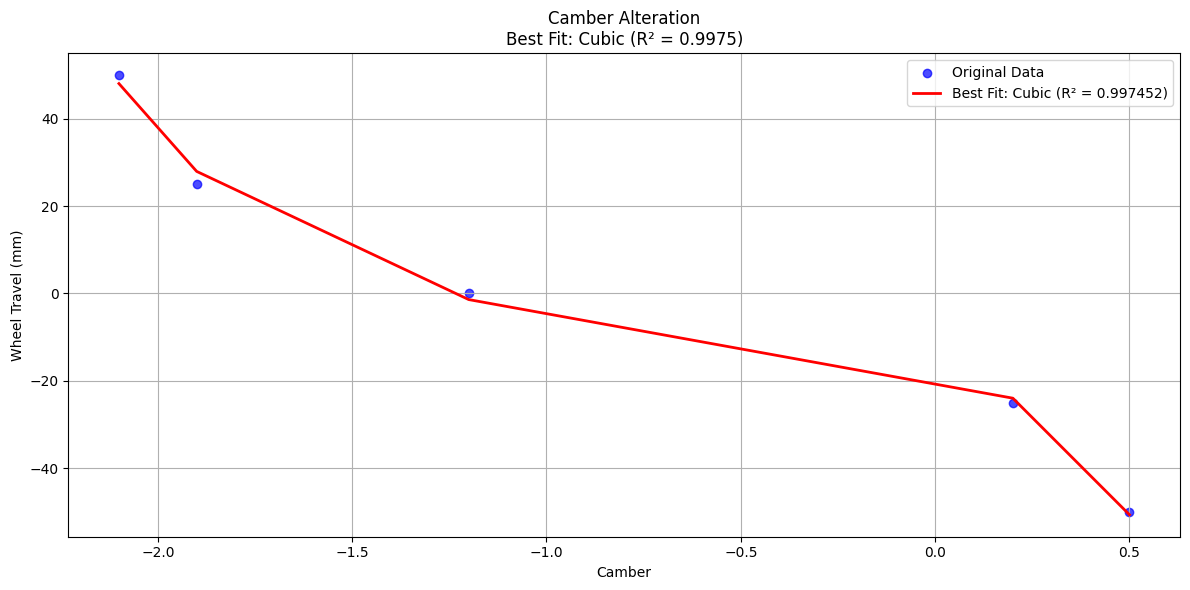


TOE ANGLE → WHEEL TRAVEL

Analyzing Toe data (n=5)
Linear       - R²: 0.972973
Quadratic    - R²: 0.997054
Cubic        - R²: 0.999865
Power        - R²: 0.009502
Exponential  - R²: 0.995858
Logarithmic  - R²: 0.220778
Sinusoidal   - R²: 0.999834

Best fit for Toe: Cubic
Function parameters: [5345.91189831 1239.89217809 -431.15453673  -24.66307274]


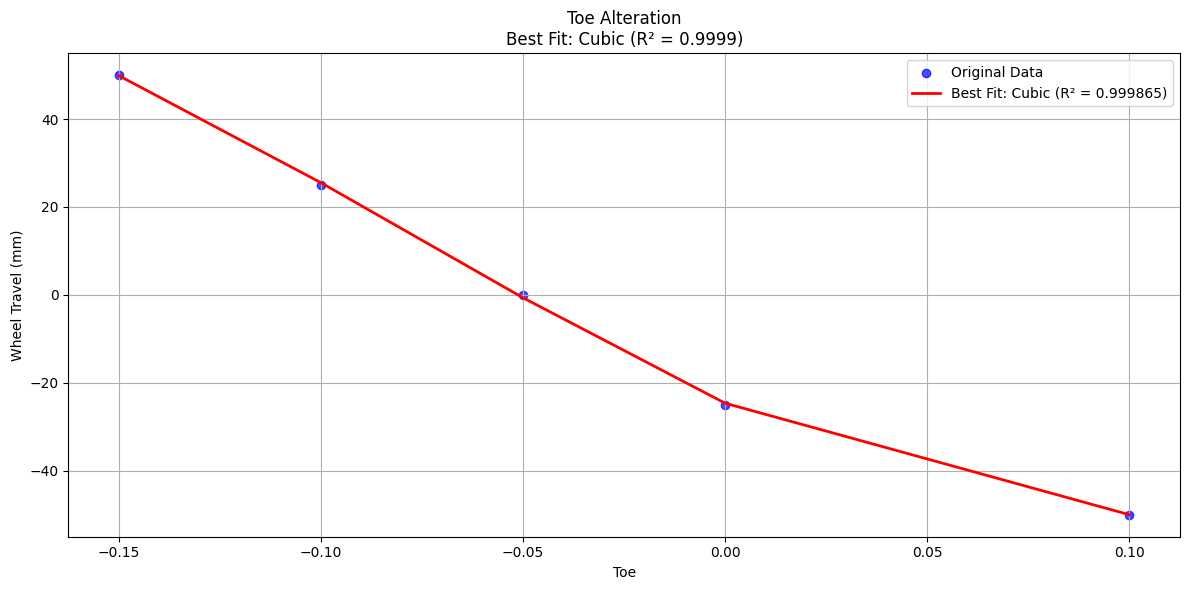

In [4]:
# Input data
camber_angles = np.array([0.5, 0.2, -1.2, -1.9, -2.1])  # degrees (independent)
wheel_travel = np.array([-50, -25, 0, 25, 50])          # mm (dependent)
toe_angles = np.array([0.01, 0, -0.01, -0.02, -0.04])   # degrees (independent)

# Camber angle vs wheel travel analysis
print("\nCAMBER ANGLE → WHEEL TRAVEL")
camber_result = find_best_fit(camber_angles, wheel_travel, "Camber")
plot_results(camber_angles, wheel_travel, camber_result, "Camber")

# Toe angle vs wheel travel analysis
print("\nTOE ANGLE → WHEEL TRAVEL")
toe_result = find_best_fit(toe_angles, wheel_travel, "Toe")
plot_results(toe_angles, wheel_travel, toe_result, "Toe")

#### Objective Camber Curve:
$s(\epsilon) = -22.96634834 x^3 - 54.31766864 x^2 - 41.96792673 x -13.22145237$

#### Objective Toe Curve:
$s(\tau) = 6.68239004e+05 x^3 + 9.09703552e+03 x^2 + -2.59377808e+03 x + -2.55053909e+01$

### 4. Optimization

#### Implementation Steps: Regression-Based Approach

1. Fit a meta-model (e.g., polynomial or neural network) to predict camber/toe from hardpoints.

2. Optimize the meta-model to find hardpoints that minimize error.

#### 4.1. Normalization and Spliting (Preprocessing)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X = suspension_df[["hpl_top_mount.y", "hpl_lca_outer.z", "hpl_lca_front.z"]]
y = suspension_df[["camber_angle", "toe_angle"]]
# Split the data into training and temporary sets (80% train, 20% temporary)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
sc = StandardScaler()
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

#### 4.2. Model Training

In [6]:
from sklearn.neural_network import MLPRegressor

# Initialize and train MLP
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # 2 hidden layers
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2
)

mlp.fit(X_train_scaled, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 50), max_iter=500,
             random_state=42, validation_fraction=0.2)

#### 4.3. Training Progress Visualization

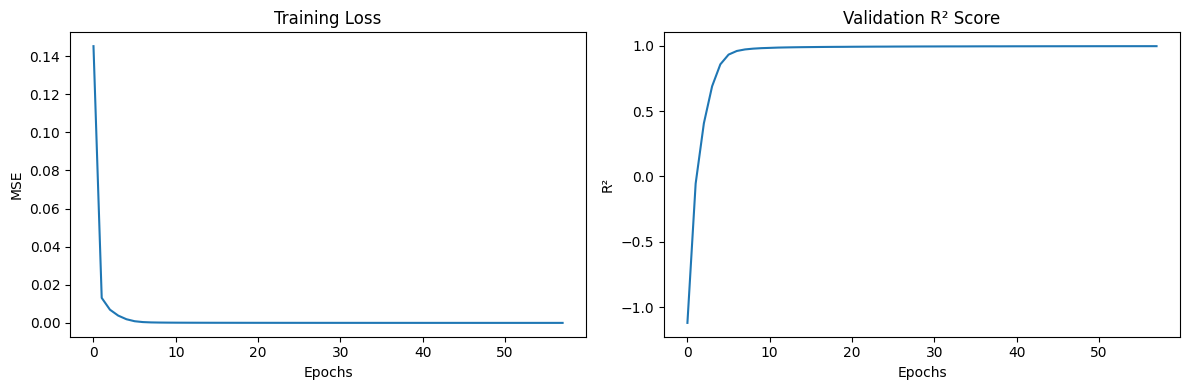

In [7]:
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

# Plot validation score
plt.subplot(1, 2, 2)
plt.plot(mlp.validation_scores_)
plt.title('Validation R² Score')
plt.xlabel('Epochs')
plt.ylabel('R²')

plt.tight_layout()
plt.show()

#### 4.3. Evaluation

Train R²: 0.998
Test R²: 0.998
Test MSE: 0.000


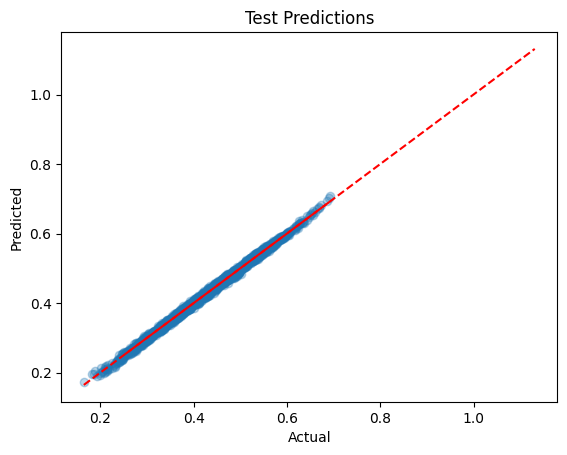

In [8]:
from sklearn.metrics import mean_squared_error

# Make predictions
train_pred = mlp.predict(X_train_scaled)
test_pred = mlp.predict(X_test_scaled)

# Calculate metrics
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test MSE: {mean_squared_error(y_test, test_pred):.3f}")

# Quick prediction plot
plt.scatter(y_test.iloc[:, 0], test_pred[:, 0], alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Predictions')
plt.show()

#### 4.4. Define the Optimization Problem and the Objective Functions

In [9]:
def camber_curve(x):
    return -48.76258113 * x**3 + 3.03680145 * x**2 - 37.87645218 * x - 28.72789553

def toe_curve(x):
    return 26.12141996 * x**3 + 59.97397949 * x**2 + 79.71489359 * x + 6.19447021

def camber_objective(x):
    return -22.96634834 * x**3 - 54.31766864 * x**2 - 41.96792673 * x -13.22145237

def toe_objective(x):
    return 6.68239004e+05 * x**3 + 9.09703552e+03 * x**2 - 2.59377808e+03 * x - 2.55053909e+01


In [10]:
def loss_function(hardpoints_scaled):
    # Predict camber and toe angles
    camber_pred, toe_pred = mlp.predict([hardpoints_scaled])[0]

    # Evaluate wheel travel from predicted angles
    s_camber = camber_curve(camber_pred)
    s_toe = toe_curve(toe_pred)

    # Evaluate objective wheel travel
    s_camber_obj = camber_objective(camber_pred)
    s_toe_obj = toe_objective(toe_pred)

    # Compute squared error
    camber_error = (s_camber - s_camber_obj)**2
    toe_error = (s_toe - s_toe_obj)**2

    return camber_error + toe_error


#### 4.5. Constraints and Scaling

In [11]:
# Physical bounds
bounds_physical = {
    'hpl_top_mount.y': (-600, -560),
    'hpl_lca_outer.z': (155, 195),
    'hpl_lca_front.z': (170, 210)
}

# Convert bounds to scaled space
X_bounds = np.array([
    bounds_physical['hpl_top_mount.y'],
    bounds_physical['hpl_lca_outer.z'],
    bounds_physical['hpl_lca_front.z']
])

# Scale bounds
X_bounds_scaled = sc.transform(X_bounds.T).T  # shape (3, 2)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


#### 4.6. Optimize the Hardpoints

In [12]:
from scipy.optimize import minimize

# Initial guess: scaled mean of training data
initial_guess = np.mean(X_train_scaled, axis=0)

# Use L-BFGS-B with bounds
result = minimize(
    loss_function,
    initial_guess,
    method='L-BFGS-B',
    bounds=X_bounds_scaled,
    options={'maxiter': 1000}
)

# Get optimized hardpoints in physical space
optimized_scaled = result.x
optimized_hardpoints = sc.inverse_transform([optimized_scaled])[0]

# Map to column names
optimized_dict = dict(zip(X.columns, optimized_hardpoints))


#### 4.7. Optimization Results

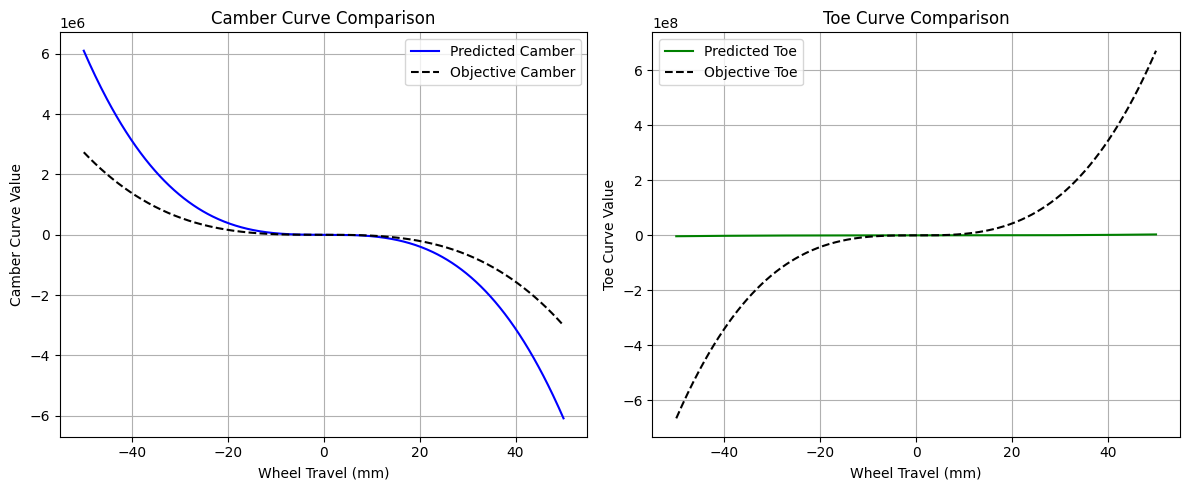

In [17]:
# Wheel travel range
x_vals = np.linspace(-50, 50, 500)

# Evaluate curves
camber_pred_vals = camber_curve(x_vals)
camber_obj_vals = camber_objective(x_vals)

toe_pred_vals = toe_curve(x_vals)
toe_obj_vals = toe_objective(x_vals)

# Plotting
plt.figure(figsize=(12, 5))

# Camber subplot
plt.subplot(1, 2, 1)
plt.plot(x_vals, camber_pred_vals, label="Predicted Camber", color='blue')
plt.plot(x_vals, camber_obj_vals, label="Objective Camber", linestyle='--', color='black')
plt.title("Camber Curve Comparison")
plt.xlabel("Wheel Travel (mm)")
plt.ylabel("Camber Curve Value")
plt.grid(True)
plt.legend()

# Toe subplot
plt.subplot(1, 2, 2)
plt.plot(x_vals, toe_pred_vals, label="Predicted Toe", color='green')
plt.plot(x_vals, toe_obj_vals, label="Objective Toe", linestyle='--', color='black')
plt.title("Toe Curve Comparison")
plt.xlabel("Wheel Travel (mm)")
plt.ylabel("Toe Curve Value")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
optimized_dict

{'hpl_top_mount.y': -599.8660475464231,
 'hpl_lca_outer.z': 155.0,
 'hpl_lca_front.z': 207.29515314380947}